In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import PchipInterpolator
import os
import sys
import json
import jdata as jd

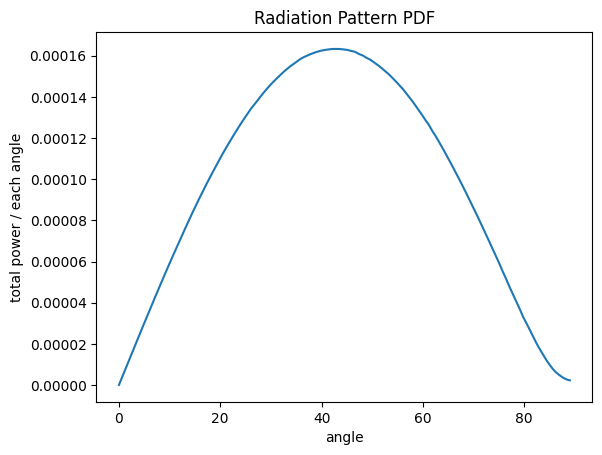

In [37]:
LED_profile = pd.read_csv("LED_profile_in3D_pfForm_0to89.csv").to_numpy()
angle, ledProfileIn3D = LED_profile[:,0],  LED_profile[:, 1]
plt.title("Radiation Pattern PDF")
plt.plot(angle, ledProfileIn3D)
plt.ylabel("total power / each angle")
plt.xlabel("angle")
plt.show()

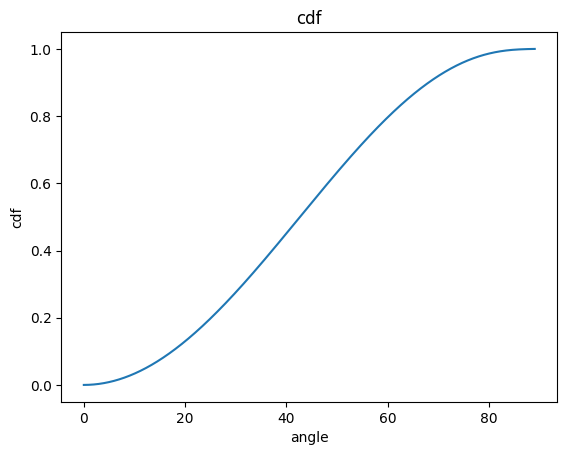

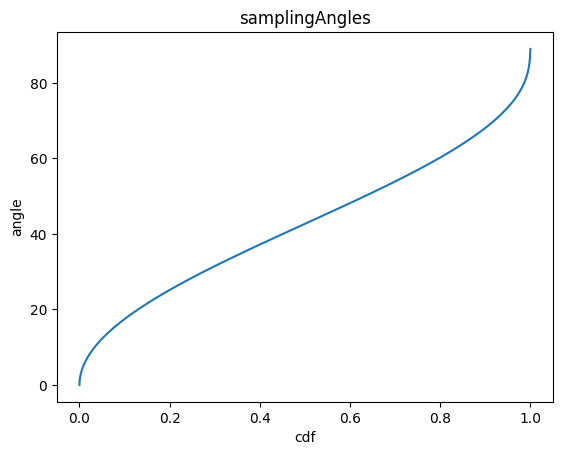

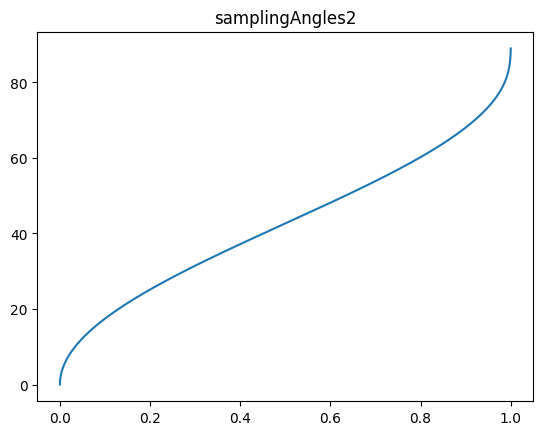

In [38]:
ledProfileIn3D = pd.read_csv("LED_profile_in3D_pfForm_0to89.csv").to_numpy()

angle = ledProfileIn3D[:, 0]
cdf = np.cumsum(ledProfileIn3D[:, 1])
inversecdf = PchipInterpolator(cdf, angle)
samplingSeeds = np.linspace(0, 1, num=10000)
samplingAngles = inversecdf(samplingSeeds)
plt.title("cdf")
plt.plot(angle, cdf)
plt.ylabel("cdf")
plt.xlabel("angle")
plt.show()

plt.title("samplingAngles")
plt.plot(samplingSeeds, samplingAngles)
plt.xlabel("cdf")
plt.ylabel("angle")
plt.show()

plt.title("samplingAngles2")
plt.plot(cdf, angle)
plt.show()

In [42]:
mcxInput = {}
mcxInput["Session"] = {}
mcxInput["Session"]["ID"] = "test"
mcxInput["Session"]["DoNormalize"] = 1

mcxInput["Forward"] = {"T0": 0.0, "Dt": 5e-09, "T1": 5e-09}

mcxInput["Domain"] = {}
mcxInput["Domain"]["Media"] = [{"n" : 1.457, "g" : 1, "name": "0: Fiber", "mua" :  0, "mus" : 0},
                               {"n" : 1.4, "g" : 0.9, "name": "1: medium1", "mua" :  100000, "mus" : 1}]
mcxInput["Domain"]["Dim"] = [120,120,120]
mcxInput["Domain"]["OriginType"] = 1
vol = np.ones((120,120,120))
vol[30,30,0] = 0
vol = vol.astype(np.uint8)
mcxInput["Shapes"] = vol

ledProfileIn3D = pd.read_csv("LED_profile_in3D_pfForm_0to89.csv").to_numpy()
angle = ledProfileIn3D[:, 0]
cdf = np.cumsum(ledProfileIn3D[:, 1])
inversecdf = PchipInterpolator(cdf, angle)
samplingSeeds = np.linspace(0, 1, num=100000)
samplingAngles = inversecdf(samplingSeeds)
samplingAngles = np.deg2rad(samplingAngles).tolist()
mcxInput["Optode"] = {}
mcxInput["Optode"]["Detector"] = [{"R": 1.47, "Pos": [30,30,0]}]
mcxInput["Optode"]["Source"] = {"Type": "anglepattern", "Pos": [60, 60, -1e-5], "Dir": [0, 0, 1], 
                                "Param1": [100000, 5, 5, 0], "Param2": [20, 20, 0, 24.0], 
                                "Pattern": {"Nx": 100000, "Ny": 1, "Nz": 1, "Data": samplingAngles}}


# save mcxInput to output/json_output
jd.save(jd.encode(mcxInput, {'compression': 'zlib', 'base64': 1}),
        "input_test.json")

sessionName = "test"
root = os.path.join("mcx_output")
os.makedirs(root, exist_ok=True)
# make up command
if os.name == "posix":
    # linux
    command = "./mcx"
elif os.name == "nt":
    # windows
    command = "mcx.exe"
else:
    command = "./mcx"
command += " --session {} ".format(sessionName)
command += "--input {} ".format("input_test.json")
command += "--root {} ".format(root)
command += "--gpu 1 "  # use first gpu
command += "--autopilot 1 "
command += "--photon {} ".format(1e7)
command += "--repeat 1 "
command += "--normalize 1 "
command += "--bc aaaaar "
command += "--unitinmm {} ".format(1)
command += "--skipradius -2 "
command += "--array 0 "
command += "--dumpmask 0 "
command += "--maxdetphoton {} ".format(3e7)
command += "--srcfrom0 1 "
command += "--saveseed 1 "
command += "--debug P "
command += "--savedetflag DSPXV --seed -1 --outputformat jnii"
with open("used_command.txt", "w") as f:
    f.write(command)
command += ">> log.txt"
print(command)

mcx.exe --session test --input input_test.json --root mcx_output --gpu 1 --autopilot 1 --photon 10000000.0 --repeat 1 --normalize 1 --bc aaaaar --unitinmm 1 --skipradius -2 --array 0 --dumpmask 0 --maxdetphoton 30000000.0 --srcfrom0 1 --saveseed 1 --debug P --savedetflag DSPXV --seed -1 --outputformat jnii>> log.txt


In [43]:
# run
sys.stdout.flush()
# currentDir = os.getcwd()
# os.chdir(os.path.join(os.getcwd(), "bin"))
# print("Current position to run MCX:\n", os.getcwd(), end="\n\n")
# print("Command sent to MCX:\n{}".format(command), end="\n\n")
print("∎∎ Start to run test ...")
os.system(command)
print("Finished !! ∎∎", end="\n\n")
# os.chdir(currentDir)

∎∎ Start to run test ...
Finished !! ∎∎



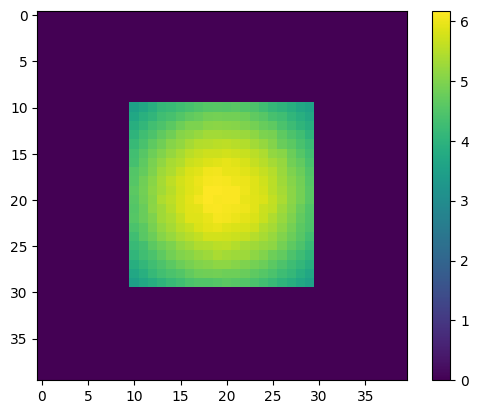

In [44]:
a = jd.load(os.path.join("mcx_output", "test.jnii"))
# plt.plot(a["NIFTIData"].sum(axis=(0, 1)))
plt.imshow(a["NIFTIData"][40:80,40:80,0])
plt.colorbar()
plt.show()


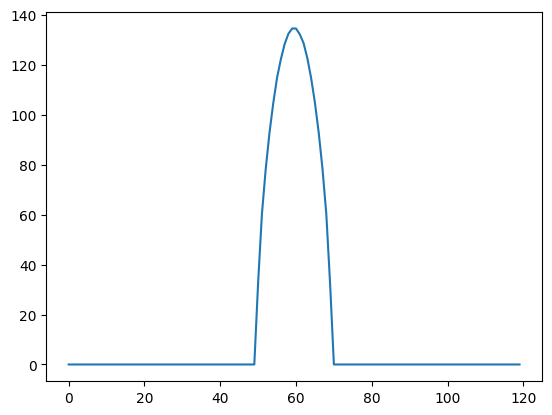

In [33]:
plt.plot(a["NIFTIData"].sum(axis=(1, 2)))
plt.show()